# Analyze r/loseit Challenge Data

Now we can read in the already cleaned file. If you don't have the cleaned data, you will need to run [Find and Clean Loseit Data](clean_loseit_challenge_data.ipynb).

In [173]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import datetime as dt
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import os
color = sns.color_palette()
from IPython.display import display, HTML
from collections import Counter

%matplotlib inline

In [128]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/coreys/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/coreys/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/coreys/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We begin by loading in the dataset and look at the counts.

In [152]:
big_df = pd.read_csv('./data/cleaned_and_combined_loseit_challenge_data.csv', index_col=0)
big_df['NSV Text'] = big_df['NSV Text'].astype(str).replace('nan', '')
len(big_df)

7859

Now we want to start looking at some of the statistics for the participants.

In [153]:
display(big_df.sort_values(by='Age').head())
display(big_df.sort_values(by='Age', ascending=False).head())

,Timestamp,Username,Team,Age,Gender,Height,Highest Weight,Starting Weight,Challenge Goal Weight,Starting BMI,Has NSV,Has Food Tracker,Has Activity Tracker,NSV Text,Challenge Goal Loss,Final Weight,Total Challenge Loss,Challenge Percentage Lost,Percent of Challenge Goal
5993,7/15/2016 13:18:30,Spartan117g,SUNSHINE,1.0,Male,31.0,165.0,181.0,171.0,132.41,0,0,0,,10.0,178.0,3.0,1.657459,30.000000
1066,6/2/2017 9:56:52,FattyTeen12,Deadpool,13.0,Unknown,58.0,125.0,90.3,90.0,19.43,1,1,1,To begin a healthy life style,0.3,88.0,2.3,2.547065,766.666667
1758,6/11/2017 13:28:15,Elessar_Inman,Batman,14.0,Unknown,69.0,143.0,137.5,130.0,20.72,1,0,0,To get ripped!,7.5,137.0,0.5,0.363636,6.666667
264,3/23/2018 19:40:15,thehealthymt,Dragon,14.0,Female,66.0,252.0,232.0,229.0,37.44,1,1,0,Fit into L hoodie,3.0,229.9,2.1,0.905172,70.000000
3694,1/8/2017 14:26:41,cantthinkofanything3,Snake,14.0,Male,65.0,215.0,207.5,200.0,34.53,1,0,0,Be able to control the amount of food I eat wi...,7.5,200.4,7.1,3.421687,94.666667


,Timestamp,Username,Team,Age,Gender,Height,Highest Weight,Starting Weight,Challenge Goal Weight,Starting BMI,Has NSV,Has Food Tracker,Has Activity Tracker,NSV Text,Challenge Goal Loss,Final Weight,Total Challenge Loss,Challenge Percentage Lost,Percent of Challenge Goal
899,4/4/2018 13:13:16,AmIaThrowawayTotally,Yeti,100.0,Other,67.0,299.0,299.0,290.0,46.82,0,0,0,,9.0,290.0,9.0,3.010033,100.000000
5323,7/11/2018 11:42:20,AmIaThrowAwayTotally,Shadowfax,100.0,Other,67.0,200.0,200.0,190.0,31.32,1,0,0,"Drink more water, take 7000+ steps per day.",10.0,196.5,3.5,1.750000,35.000000
1006,4/12/2018 12:33:46,patchet44,Cerberus,76.0,Female,68.0,208.0,163.0,157.0,24.78,1,0,0,better health,6.0,159.9,3.1,1.901840,51.666667
4968,7/1/2018 18:29:57,mcculloughronnie75,Shadowfax,76.0,Female,61.0,175.0,166.0,155.0,31.36,1,0,1,So I can fit into smaller and cuter clothes,11.0,162.0,4.0,2.409639,36.363636
2049,1/6/2018 18:33:51,mcculloughronnie75,Hamster,75.0,Female,61.0,175.0,171.0,159.0,32.31,1,0,0,Fit into 12 petite,12.0,168.0,3.0,1.754386,25.000000


Here we can see that there are outliers at both the young and old end of the age spectrum. So I will look to see if they ever entered with a different age, and if not I will remove them from any age analysis.

In [154]:
display(big_df[big_df.Username == 'AmIaThrowawayTotally'])
display(big_df[big_df.Username == 'AmIaThrowAwayTotally'])
display(big_df[big_df.Username == 'Spartan117g'])

,Timestamp,Username,Team,Age,Gender,Height,Highest Weight,Starting Weight,Challenge Goal Weight,Starting BMI,Has NSV,Has Food Tracker,Has Activity Tracker,NSV Text,Challenge Goal Loss,Final Weight,Total Challenge Loss,Challenge Percentage Lost,Percent of Challenge Goal
899,4/4/2018 13:13:16,AmIaThrowawayTotally,Yeti,100.0,Other,67.0,299.0,299.0,290.0,46.82,0,0,0,,9.0,290.0,9.0,3.010033,100.0


,Timestamp,Username,Team,Age,Gender,Height,Highest Weight,Starting Weight,Challenge Goal Weight,Starting BMI,Has NSV,Has Food Tracker,Has Activity Tracker,NSV Text,Challenge Goal Loss,Final Weight,Total Challenge Loss,Challenge Percentage Lost,Percent of Challenge Goal
5323,7/11/2018 11:42:20,AmIaThrowAwayTotally,Shadowfax,100.0,Other,67.0,200.0,200.0,190.0,31.32,1,0,0,"Drink more water, take 7000+ steps per day.",10.0,196.5,3.5,1.75,35.0


,Timestamp,Username,Team,Age,Gender,Height,Highest Weight,Starting Weight,Challenge Goal Weight,Starting BMI,Has NSV,Has Food Tracker,Has Activity Tracker,NSV Text,Challenge Goal Loss,Final Weight,Total Challenge Loss,Challenge Percentage Lost,Percent of Challenge Goal
784,3/30/2018 18:04:27,Spartan117g,Phoenix,21.0,Male,67.0,196.0,163.6,160.0,25.62,1,0,0,Feel better,3.6,162.0,1.6,0.977995,44.444444
5993,7/15/2016 13:18:30,Spartan117g,SUNSHINE,1.0,Male,31.0,165.0,181.0,171.0,132.41,0,0,0,,10.0,178.0,3.0,1.657459,30.000000


Ok, so we will need to ignore the age 100 entries, but we can replace the age 1 entry -- as well as the height of 31 inches.

In [155]:
big_df.Age.replace(1.0, 19.0, inplace=True)
big_df.Height.replace(31.0, 67.0, inplace=True)
display(big_df[big_df.Username == 'Spartan117g'])
age_df = big_df[big_df.Age < 100]

,Timestamp,Username,Team,Age,Gender,Height,Highest Weight,Starting Weight,Challenge Goal Weight,Starting BMI,Has NSV,Has Food Tracker,Has Activity Tracker,NSV Text,Challenge Goal Loss,Final Weight,Total Challenge Loss,Challenge Percentage Lost,Percent of Challenge Goal
784,3/30/2018 18:04:27,Spartan117g,Phoenix,21.0,Male,67.0,196.0,163.6,160.0,25.62,1,0,0,Feel better,3.6,162.0,1.6,0.977995,44.444444
5993,7/15/2016 13:18:30,Spartan117g,SUNSHINE,19.0,Male,67.0,165.0,181.0,171.0,132.41,0,0,0,,10.0,178.0,3.0,1.657459,30.000000


The next component we will look at is height.

In [156]:
display(big_df.sort_values(by='Height').head())
display(big_df.sort_values(by='Height', ascending=False).head())

,Timestamp,Username,Team,Age,Gender,Height,Highest Weight,Starting Weight,Challenge Goal Weight,Starting BMI,Has NSV,Has Food Tracker,Has Activity Tracker,NSV Text,Challenge Goal Loss,Final Weight,Total Challenge Loss,Challenge Percentage Lost,Percent of Challenge Goal
7887,4/4/2016 11:40:21,beeckahhh,THUNDERSTORM,23.0,Female,52.0,185.0,168.0,155.0,43.68,1,1,0,Wear a medium in summer dresses,13.0,162.0,6.0,3.571429,46.153846
5431,7/7/2016 15:41:45,Verivus,BLUEBERRY,26.0,Female,52.0,143.0,118.8,110.0,30.89,1,1,1,Running a 5K without a break,8.8,120.6,-1.8,-1.515152,-20.454545
5260,7/9/2018 15:31:35,mossy-pants,2nd Breakfast,21.0,Female,52.0,166.8,157.2,152.0,40.87,1,0,1,increase cardio fitness score on fitbit,5.2,152.4,4.8,3.053435,92.307692
3682,1/6/2017 19:31:50,g-rain,Snake,25.0,Female,52.0,222.0,186.0,176.0,48.36,1,1,1,Improving strength and stamina,10.0,174.0,12.0,6.451613,120.000000
4662,6/29/2018 13:38:35,myfamilyworriessome,Frodo and Sam,27.0,Female,52.0,164.2,150.6,140.0,39.15,1,0,0,Fit into my little blue dress for a wedding in...,10.6,144.2,6.4,4.249668,60.377358


,Timestamp,Username,Team,Age,Gender,Height,Highest Weight,Starting Weight,Challenge Goal Weight,Starting BMI,Has NSV,Has Food Tracker,Has Activity Tracker,NSV Text,Challenge Goal Loss,Final Weight,Total Challenge Loss,Challenge Percentage Lost,Percent of Challenge Goal
8267,10/29/2017 12:21:10,Mercer022,Lynx,22.0,Male,189.0,216.0,216.0,200.0,4.25,1,1,0,To start jogging,16.0,209.0,7.0,3.240741,43.750000
8635,11/8/2017 20:18:11,SkyDweller-Entropist,Panda,21.0,Male,82.6,216.0,216.0,200.0,22.26,0,1,0,,16.0,220.0,-4.0,-1.851852,-25.000000
7201,4/6/2016 21:26:42,Sportsfreaktony,DUCKLING,25.0,Male,82.0,250.0,230.0,200.0,24.05,0,0,0,,30.0,219.0,11.0,4.782609,36.666667
3513,1/6/2017 10:46:53,nfaber06,Phoenix,28.0,Male,82.0,430.0,398.0,375.0,41.61,1,0,0,Fit in old clothes,23.0,384.0,14.0,3.517588,60.869565
430,3/25/2018 6:50:18,jeffles2,Dragon,42.0,Male,81.0,275.0,245.0,240.0,26.25,1,0,0,Stick to elimination diet,5.0,224.6,20.4,8.326531,408.000000


In [157]:
big_df[big_df.Username == 'Mercer022']

,Timestamp,Username,Team,Age,Gender,Height,Highest Weight,Starting Weight,Challenge Goal Weight,Starting BMI,Has NSV,Has Food Tracker,Has Activity Tracker,NSV Text,Challenge Goal Loss,Final Weight,Total Challenge Loss,Challenge Percentage Lost,Percent of Challenge Goal
1430,6/4/2017 14:13:24,Mercer022,Deadpool,22.0,Unknown,74.4,260.0,229.2,220.0,29.97,1,0,0,To start jogging,9.2,224.8,4.4,1.919721,47.826087
7832,4/1/2016 13:21:19,Mercer022,SEEDLING,21.0,Male,74.0,286.6,260.0,242.0,33.38,0,0,0,,18.0,250.0,10.0,3.846154,55.555556
8267,10/29/2017 12:21:10,Mercer022,Lynx,22.0,Male,189.0,216.0,216.0,200.0,4.25,1,1,0,To start jogging,16.0,209.0,7.0,3.240741,43.750000


In [158]:
big_df.Height.replace(189.0, 74.0, inplace=True)
# we also need to fix the BMI, for 74 inches and 216 lbs, bmi = 27.7
big_df['Starting BMI'].replace(4.25, 27.7, inplace=True)
big_df[big_df.Username == 'Mercer022']

,Timestamp,Username,Team,Age,Gender,Height,Highest Weight,Starting Weight,Challenge Goal Weight,Starting BMI,Has NSV,Has Food Tracker,Has Activity Tracker,NSV Text,Challenge Goal Loss,Final Weight,Total Challenge Loss,Challenge Percentage Lost,Percent of Challenge Goal
1430,6/4/2017 14:13:24,Mercer022,Deadpool,22.0,Unknown,74.4,260.0,229.2,220.0,29.97,1,0,0,To start jogging,9.2,224.8,4.4,1.919721,47.826087
7832,4/1/2016 13:21:19,Mercer022,SEEDLING,21.0,Male,74.0,286.6,260.0,242.0,33.38,0,0,0,,18.0,250.0,10.0,3.846154,55.555556
8267,10/29/2017 12:21:10,Mercer022,Lynx,22.0,Male,74.0,216.0,216.0,200.0,27.70,1,1,0,To start jogging,16.0,209.0,7.0,3.240741,43.750000


The next stat is starting weight.

In [159]:
display(big_df.sort_values(by='Total Challenge Loss').head(15))
display(big_df.sort_values(by='Total Challenge Loss', ascending=False).head(5))

,Timestamp,Username,Team,Age,Gender,Height,Highest Weight,Starting Weight,Challenge Goal Weight,Starting BMI,Has NSV,Has Food Tracker,Has Activity Tracker,NSV Text,Challenge Goal Loss,Final Weight,Total Challenge Loss,Challenge Percentage Lost,Percent of Challenge Goal
2669,1/7/2018 2:35:44,LeMasterOfSwag,Teacup Pig,21.0,Female,59.8,124.6,104.1,100.3,20.46,1,1,1,See my shoulder bones,3.8,219.97,-115.87,-111.306436,-3049.210526
732,3/29/2018 14:41:57,Kivotheginger,Yeti,21.0,Male,72.0,270.0,164.0,245.0,22.24,1,1,0,Workout 4 times per week,-81.0,268.00,-104.00,-63.414634,128.395062
2857,1/11/2018 4:26:54,avoidsummer,Turtle,33.0,Female,65.0,314.0,289.0,280.0,48.09,1,0,0,To visit the gym on a regular basis and do a m...,9.0,384.00,-95.00,-32.871972,-1055.555556
539,3/26/2018 11:22:00,raelinxovern,Chupacabra,23.0,Male,74.0,420.0,386.8,365.0,49.66,1,1,0,Not have to rest hands on gut while on the phone,21.8,469.00,-82.20,-21.251293,-377.064220
5549,7/15/2016 16:21:29,rtriv85,BUTTERFLY,31.0,Female,65.0,164.0,158.5,139.0,26.37,1,0,1,Start wearing my size 8 & size 10 dresses agai...,19.5,240.00,-81.50,-51.419558,-417.948718
7256,4/12/2016 7:26:31,Jennyy1,FAWN,26.0,Female,59.0,189.0,159.4,150.0,32.19,1,1,1,Loss of belly fat (post preg),9.4,185.50,-26.10,-16.373902,-277.659574
6362,8/19/2017 4:42:53,Bonsai1001,Alien,29.0,Female,67.0,180.0,139.0,129.0,21.80,1,1,1,Losing a jeans size,10.0,158.00,-19.00,-13.669065,-190.000000
3278,1/6/2017 11:42:42,cattipotato,Phoenix,22.0,Female,63.0,250.0,220.2,215.0,39.00,1,0,0,Gym 4x/week,5.2,238.00,-17.80,-8.083560,-342.307692
7165,4/3/2016 10:46:43,InputZero,DUCKLING,26.0,Male,69.0,280.0,188.0,175.0,27.76,1,1,1,To fit my old clothea,13.0,205.00,-17.00,-9.042553,-130.769231
5183,7/7/2018 1:05:18,TwerkForGold,Ents,24.0,Female,72.0,360.0,319.5,300.0,43.33,1,1,0,Fit into new gym clothes better,19.5,335.00,-15.50,-4.851330,-79.487179


,Timestamp,Username,Team,Age,Gender,Height,Highest Weight,Starting Weight,Challenge Goal Weight,Starting BMI,Has NSV,Has Food Tracker,Has Activity Tracker,NSV Text,Challenge Goal Loss,Final Weight,Total Challenge Loss,Challenge Percentage Lost,Percent of Challenge Goal
423,3/25/2018 3:55:15,Fralance,Chupacabra,18.0,Male,71.0,250.0,248.4,230.0,34.64,1,1,0,To get back on track,18.4,111.3,137.1,55.193237,745.108696
619,3/27/2018 14:08:37,rainishamy,Unicorn,44.0,Female,69.0,340.0,309.8,292.0,45.74,1,1,0,need smaller pants,17.8,197.6,112.2,36.216914,630.337079
265,3/23/2018 19:48:41,Mandatech,Phoenix,34.0,Female,66.0,235.0,221.3,215.0,35.71,1,0,0,Zip the boots again,6.3,115.9,105.4,47.627655,1673.015873
244,3/23/2018 18:17:12,alakazam1111,Dragon,17.0,Female,59.0,167.0,141.5,135.0,28.58,0,0,0,,6.5,64.5,77.0,54.416961,1184.615385
907,4/4/2018 23:17:19,helpmeloseit247,Pegasus,26.0,Female,65.0,350.0,335.7,325.0,55.86,1,1,0,Write in my journal every night,10.7,290.0,45.7,13.613345,427.102804


So we need to ignore the 4 entries with a total loss of more than 50 lbs lost and the 6 entries gaining more than 20lbs during the entry.

In [160]:
loss_df = big_df[big_df['Total Challenge Loss'] > 50]
loss_df = loss_df[loss_df['Total Challenge Loss'] < -20]

Challenge Goal Loss

In [161]:
display(big_df.sort_values(by='Challenge Goal Loss').head(5))
display(big_df.sort_values(by='Challenge Goal Loss', ascending=False).head(15))

,Timestamp,Username,Team,Age,Gender,Height,Highest Weight,Starting Weight,Challenge Goal Weight,Starting BMI,Has NSV,Has Food Tracker,Has Activity Tracker,NSV Text,Challenge Goal Loss,Final Weight,Total Challenge Loss,Challenge Percentage Lost,Percent of Challenge Goal
4620,6/29/2018 12:18:12,Schrodinger_Dog,Rivendell,27.0,Male,70.0,318.0,254.0,345.0,36.44,1,0,0,Go to the gym 5 times a week,-91.0,243.2,10.8,4.251969,-11.868132
732,3/29/2018 14:41:57,Kivotheginger,Yeti,21.0,Male,72.0,270.0,164.0,245.0,22.24,1,1,0,Workout 4 times per week,-81.0,268.0,-104.0,-63.414634,128.395062
7044,4/2/2016 2:40:33,dubmevertigo,DAFFODIL,21.0,Female,65.7,240.0,175.0,191.0,28.50,1,1,1,To fit comfortably in size 14,-16.0,175.0,0.0,0.000000,-0.000000
7855,4/7/2016 10:23:30,shcamannon,SEEDLING,25.0,Female,67.0,185.0,150.0,166.0,23.49,1,1,0,Less back pain,-16.0,154.0,-4.0,-2.666667,25.000000
7403,4/4/2016 16:00:03,thats_ridiculous,HAYFEVER,28.0,Female,64.0,255.0,210.0,224.0,36.04,1,0,1,"Fit comfortably into my ""skinny"" jeans",-14.0,218.0,-8.0,-3.809524,57.142857


,Timestamp,Username,Team,Age,Gender,Height,Highest Weight,Starting Weight,Challenge Goal Weight,Starting BMI,Has NSV,Has Food Tracker,Has Activity Tracker,NSV Text,Challenge Goal Loss,Final Weight,Total Challenge Loss,Challenge Percentage Lost,Percent of Challenge Goal
3076,1/8/2017 6:57:31,chelle1976,Monarch,40.0,Female,65.0,215.0,204.0,15.0,33.94,1,1,0,To be able to run longer and with greater ease,189.0,201.0,3.0,1.470588,1.587302
7080,4/2/2016 20:52:40,misskateykates,DAFFODIL,28.0,Female,66.0,199.9,198.0,20.0,31.95,1,1,1,to feel comfortable in shorts,178.0,182.2,15.8,7.979798,8.876404
7541,4/3/2016 15:00:32,Stikki_Lawndart,LADYBUG,25.0,Male,67.0,323.0,320.0,180.0,50.11,1,0,1,Stick to the habits I that help me get healthy.,140.0,302.0,18.0,5.625000,12.857143
7486,4/13/2016 23:59:34,Labirynthgrl,LADYBUG,25.0,Female,67.0,281.0,279.0,150.0,43.69,1,1,0,Being able to do an invert on pole,129.0,262.6,16.4,5.878136,12.713178
5843,7/1/2016 13:48:30,Arcadia_Lynch,SUNFLOWER,28.0,Female,67.0,306.0,283.0,175.0,44.32,1,0,0,Be down one clothing size please god.,108.0,278.6,4.4,1.554770,4.074074
3274,1/11/2017 15:21:27,edubzz,Phoenix,28.0,Female,65.0,130.0,219.4,114.0,36.51,1,0,0,start a running program,105.4,222.0,-2.6,-1.185050,-2.466793
7372,4/12/2016 15:05:29,mello_yello,HAYFEVER,26.0,Male,72.0,290.0,283.0,180.0,38.38,1,1,0,Climb a fligh of stairs and not be out of breath.,103.0,280.0,3.0,1.060071,2.912621
4680,6/29/2018 14:06:03,BuzzTheToy,Gollum,32.0,Male,69.0,330.0,275.0,180.0,40.61,1,1,0,"Not miss a gym day, hit 360 days in a row goin...",95.0,264.0,11.0,4.000000,11.578947
2006,6/23/2017 14:27:39,King_Chapo,Wonder Woman,44.0,Unknown,70.0,308.0,308.0,228.0,44.19,1,1,0,Wear a size large Shirt,80.0,289.0,19.0,6.168831,23.750000
2668,1/16/2018 6:21:47,sazkoley,Ragdoll Kitten,20.0,Female,68.0,265.0,252.0,175.0,38.31,1,0,0,Size 14 dress,77.0,245.0,7.0,2.777778,9.090909


In [162]:
no_out_df.sort_values(by='Age', ascending=False).head()

,Timestamp,Username,Team,Age,Gender,Height,Highest Weight,Starting Weight,Challenge Goal Weight,Starting BMI,Has NSV,Has Food Tracker,Has Activity Tracker,Final Weight,Total Challenge Loss,Challenge Percentage Lost,Percent of Challenge Goal
899,4/4/2018 13:13:16,AmIaThrowawayTotally,Yeti,100.0,Other,67.0,299.0,299.0,290.0,46.82,0,0,0,290.0,9.0,3.010033,100.000000
5323,7/11/2018 11:42:20,AmIaThrowAwayTotally,Shadowfax,100.0,Other,67.0,200.0,200.0,190.0,31.32,1,0,0,196.5,3.5,1.750000,35.000000
4968,7/1/2018 18:29:57,mcculloughronnie75,Shadowfax,76.0,Female,61.0,175.0,166.0,155.0,31.36,1,0,1,162.0,4.0,2.409639,36.363636
1006,4/12/2018 12:33:46,patchet44,Cerberus,76.0,Female,68.0,208.0,163.0,157.0,24.78,1,0,0,159.9,3.1,1.901840,51.666667
2049,1/6/2018 18:33:51,mcculloughronnie75,Hamster,75.0,Female,61.0,175.0,171.0,159.0,32.31,1,0,0,168.0,3.0,1.754386,25.000000


In [17]:
no_out_age = no_out_df[no_out_df.Age < 100]
no_out_age = no_out_age[no_out_age.Age >1]

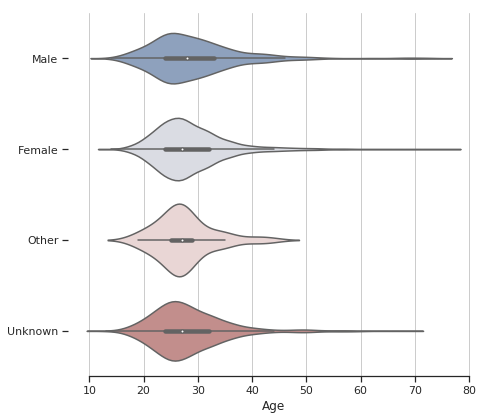

In [18]:
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(7, 6))

sns.violinplot(x='Age', y="Gender", data=no_out_age,
            palette="vlag")

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
f.tight_layout()
f.savefig('./figures/violin_gender_age.png', dpi=400)

In [39]:
out_height = big_df[big_df.Height < 100]
out_height = out_height[out_height.Height > 35]

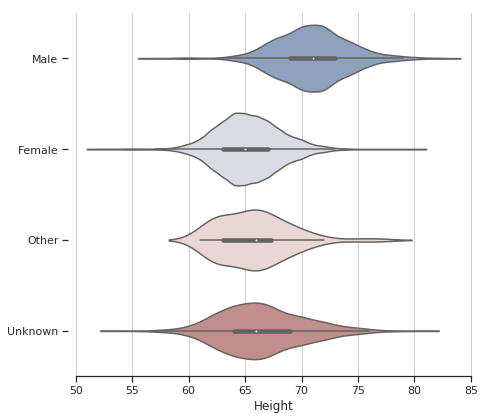

In [40]:
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(7, 6))

sns.violinplot(x='Height', y="Gender", data=out_height,
            palette="vlag")

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
f.tight_layout()
f.savefig('./figures/violin_gender_height.png', dpi=400)

In [44]:
big_df['Starting Weight'].sort_values(ascending=False).head(10)

7703    546.8
8186    501.0
5788    485.6
8508    468.0
8105    465.0
3273    463.0
8620    456.0
7357    453.0
2103    451.0
3268    448.0
Name: Starting Weight, dtype: float64

In [45]:
big_df.sort_values(by='Starting Weight', ascending=False).head(10)

,Timestamp,Username,Team,Age,Gender,Height,Highest Weight,Starting Weight,Challenge Goal Weight,Starting BMI,Has NSV,Has Food Tracker,Has Activity Tracker,Final Weight,Total Challenge Loss,Challenge Percentage Lost,Percent of Challenge Goal
7703,4/3/2016 21:33:36,hipsandjiggly,ROBIN,37.0,Female,65.0,579.0,546.8,526.0,90.98,1,1,1,529.0,17.8,3.255304,85.576923
8186,10/28/2017 1:49:33,caucasian_cranberry,Tiger,31.0,Male,72.0,501.0,501.0,460.0,67.94,1,1,0,472.0,29.0,5.788423,70.731707
5788,7/1/2016 10:08:42,invisibledreamer,SANDCASTLE,34.0,Male,71.0,599.0,485.6,465.0,67.72,1,1,0,462.6,23.0,4.736409,111.650485
8508,11/3/2017 15:41:22,37StonesStrong,Dodo,34.0,Male,69.0,468.0,468.0,433.0,69.10,1,1,0,470.0,-2.0,-0.427350,-5.714286
8105,10/27/2017 13:46:51,carnevoodoo,Rhinoceros,41.0,Male,75.0,465.0,465.0,440.0,58.11,1,1,0,442.0,23.0,4.946237,92.000000
3273,1/6/2017 10:00:58,jslowick,Monarch,34.0,Male,73.0,485.0,463.0,443.0,61.08,1,0,0,427.0,36.0,7.775378,180.000000
8620,11/7/2017 18:45:15,mcwopper,Panda,36.0,Male,72.0,456.0,456.0,444.0,61.84,1,1,0,441.0,15.0,3.289474,125.000000
7357,4/14/2016 18:26:07,ionlyfuck,HAYFEVER,23.0,Male,75.0,457.0,453.0,400.0,56.61,0,0,0,422.0,31.0,6.843267,58.490566
2103,1/9/2018 9:40:33,mcwopper,Hamster,36.0,Male,72.0,462.0,451.0,435.0,61.16,1,0,0,443.0,8.0,1.773836,50.000000
3268,1/6/2017 15:23:33,MassacreBlues,Monarch,31.0,Male,75.0,520.0,448.0,420.0,55.99,0,0,0,424.0,24.0,5.357143,85.714286


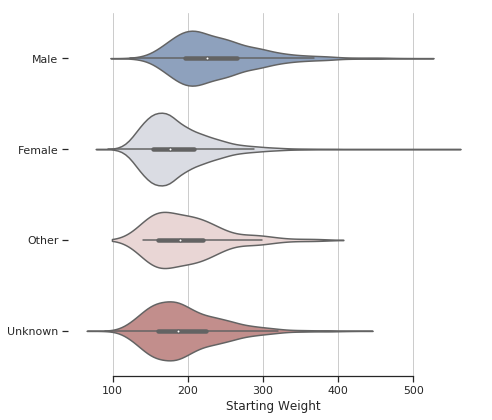

In [42]:
big_df['Starting Weight'].sort_values(ascii).head(10)

Linking Trackers

In [19]:
print(f"Gives activity tracker: {big_df['Has Activity Tracker'].sum()/len(big_df) * 100:.2f}")
print(f"Gives food tracker: {big_df['Has Food Tracker'].sum()/len(big_df) * 100:.2f}")

Gives activity tracker: 21.08
Gives food tracker: 58.53


In [20]:
print(f"Has NSV: {big_df['Has NSV'].sum()/len(big_df) * 100:.2f}")

Has NSV: 79.96


In [21]:
name_freq = big_df.Username.value_counts()

In [22]:
name_freq.head(5)

bugs_bunny01     9
axecutable       9
Lovellama        9
BlackAnemones    9
kmrbriscoe       8
Name: Username, dtype: int64

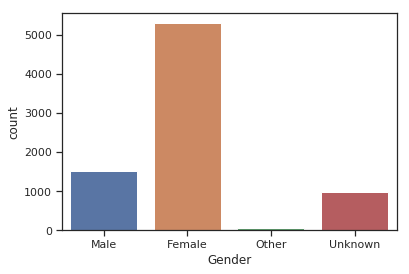

In [29]:
sns.countplot(x='Gender', data=big_df)

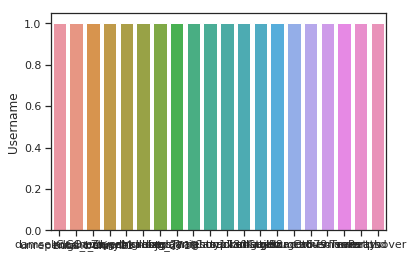

In [23]:
sns.barplot(x=big_df.Username.head(20).value_counts().index, y=big_df.Username.head(20).value_counts())

In [6]:
big_df['Percent of Challenge Goal'].mean()

68.62461376317971

In [7]:
print(len(big_df[big_df.Gender == 'Female']) / len(big_df) * 100, len(big_df[big_df.Gender == 'Male']) / len(big_df) * 100, len(big_df[big_df.Gender == 'Unknown']) / len(big_df) * 100, len(big_df[big_df.Gender == 'Other']) / len(big_df) * 100)

67.43860542053697 19.328158798829367 12.367985748823006 0.865250031810663


In [8]:
big_df.Height.mean()

66.48906419391783

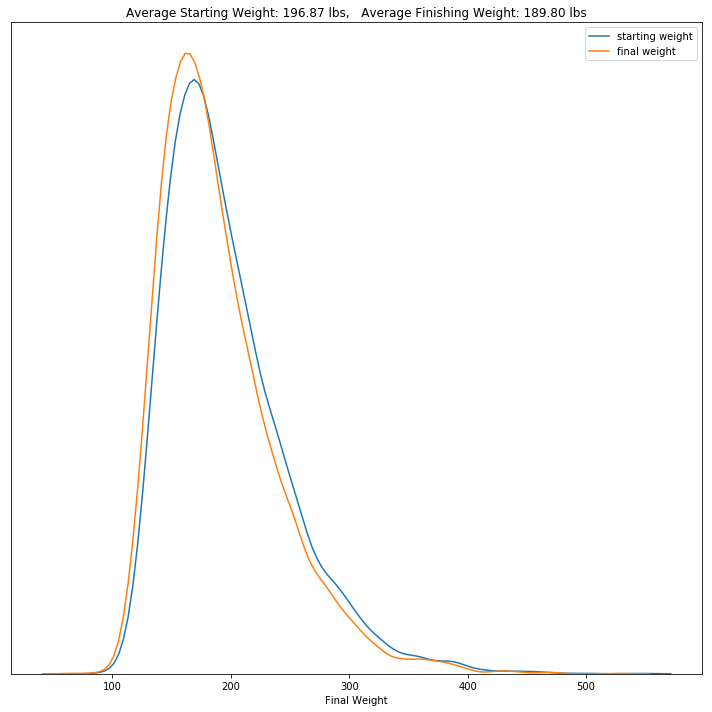

In [9]:
plt.figure(figsize=(10,10))
ax = sns.distplot(big_df['Starting Weight'], hist=False, label='starting weight')
ax = sns.distplot(big_df['Final Weight'], hist=False, label='final weight')
ax.set_yticks([])
ax.set_title(f'Average Starting Weight: {big_df["Starting Weight"].mean():.2f} lbs,   Average Finishing Weight: {big_df["Final Weight"].mean():.2f} lbs')
ax.legend()
plt.tight_layout()
plt.savefig('./figures/starting_final_weight.png', dpi=400)

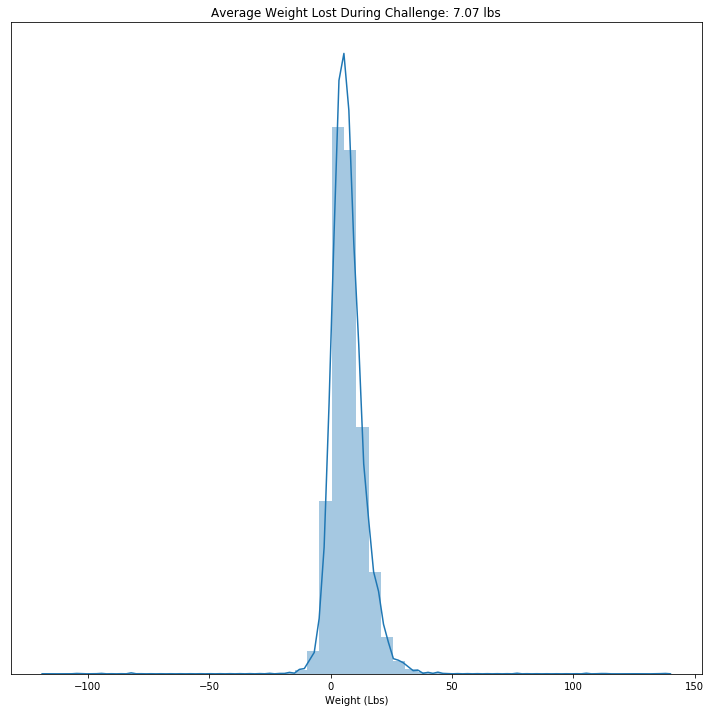

In [10]:
plt.figure(figsize=(10,10))
ax = sns.distplot(big_df['Total Challenge Loss'])
ax.set_xlabel('Weight (Lbs)')
ax.set_title(f'Average Weight Lost During Challenge: {big_df["Total Challenge Loss"].mean():.2f} lbs')
ax.set_yticks([])
plt.tight_layout()
plt.savefig('./figures/average_weight_lost.png', dpi=400)

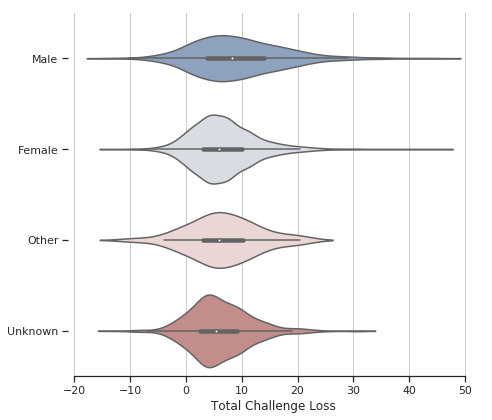

In [11]:
# remove some of the outliers for incorrect data entry
no_out_df = big_df[50 >  np.abs(big_df['Total Challenge Loss'])]
no_out_df = no_out_df[no_out_df['Total Challenge Loss'] > -15] # people are probably not gaining more than 15 lbs during the challenges 

sns.set(style="ticks")
f, ax = plt.subplots(figsize=(7, 6))

sns.violinplot(x="Total Challenge Loss", y="Gender", data=no_out_df,
            palette="vlag")

# sns.boxplot(x="Total Challenge Loss", y="Gender", data=no_out_df,
#             whis="range", palette="vlag")

# sns.swarmplot(x="Total Challenge Loss", y="Gender", data=no_out_df,
#               size=2, color=".3", linewidth=0)

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
f.tight_layout()
f.savefig('./figures/violin_gender_weight_lost.png', dpi=400)

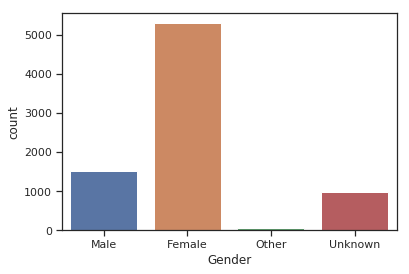

In [30]:
sns.countplot(x='Gender', data=big_df)

In [12]:
no_out_df['Total Challenge Loss'].mean()

7.100141312938182

In [218]:
Counter(big_df['NSV Text'].str.lower()).most_common(1000)

[('', 1575),
 ('fit into old clothes', 43),
 ('run a 5k', 34),
 ('run 5k', 23),
 ('finish c25k', 14),
 ('run 10k', 13),
 ('run a 10k', 10),
 ('go down a pant size', 10),
 ('run a mile', 9),
 ('fit into old jeans', 8),
 ('complete c25k', 7),
 ('fit into my old jeans', 6),
 ('drop a pant size', 6),
 ('start c25k', 6),
 ('fit into old clothes ', 5),
 ('lose a pant size', 5),
 ('fit into an old dress', 5),
 ('run faster', 5),
 ('feel better', 5),
 ('finish c25k!', 5),
 ('clothes fitting better', 5),
 ('consistency', 5),
 ('visible abs', 5),
 ('go down a pants size', 5),
 ('fit into clothes better', 5),
 ('200', 5),
 ('run a 5k without stopping', 5),
 ('have more energy', 4),
 ('fit into old clothes.', 4),
 ('size 12 jeans!', 4),
 ('run 5k without stopping', 4),
 ('run for longer distances', 4),
 ('start running again', 4),
 ('run a 5k ', 4),
 ('fitting into my old clothes', 4),
 ('log every day', 4),
 ('sub 30 minute 5k', 4),
 ('size 8 jeans', 4),
 ('feel more confident', 4),
 ('run 5km', 

In [188]:
# list of text documents
text = ["The quick brown fox jumped over the lazy dog."]
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(big_df['NSV Text'])
# summarize
print( list(vectorizer.vocabulary_.items())[:10] )
print("\n vocabulary size {}".format(len(vectorizer.vocabulary_)))
all_words = vectorizer.get_feature_names()
hot_words = vectorizer.fit_transform(big_df['NSV Text']).toarray()

[('finish', 1209), ('the', 2767), ('10k', 20), ('under', 2905), ('44mins', 215), ('fit', 1218), ('into', 1550), ('next', 1948), ('size', 2519), ('down', 1013)]

 vocabulary size 3100


In [194]:
freq = hot_words.sum(axis=0)

In [197]:
words_df = pd.DataFrame(freq)

In [202]:
words_df = words_df.T

In [203]:
words_df.columns = all_words

In [217]:
words_df[words_df.columns[words_df.loc[0].argsort()][::-1]].T.head(20)

,0
to,1593
my,1446
fit,1334
into,1208
in,865
size,752
the,685
run,617
and,581
clothes,466


In [223]:
words_df['sexy']

0    10
Name: sexy, dtype: int64

In [224]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

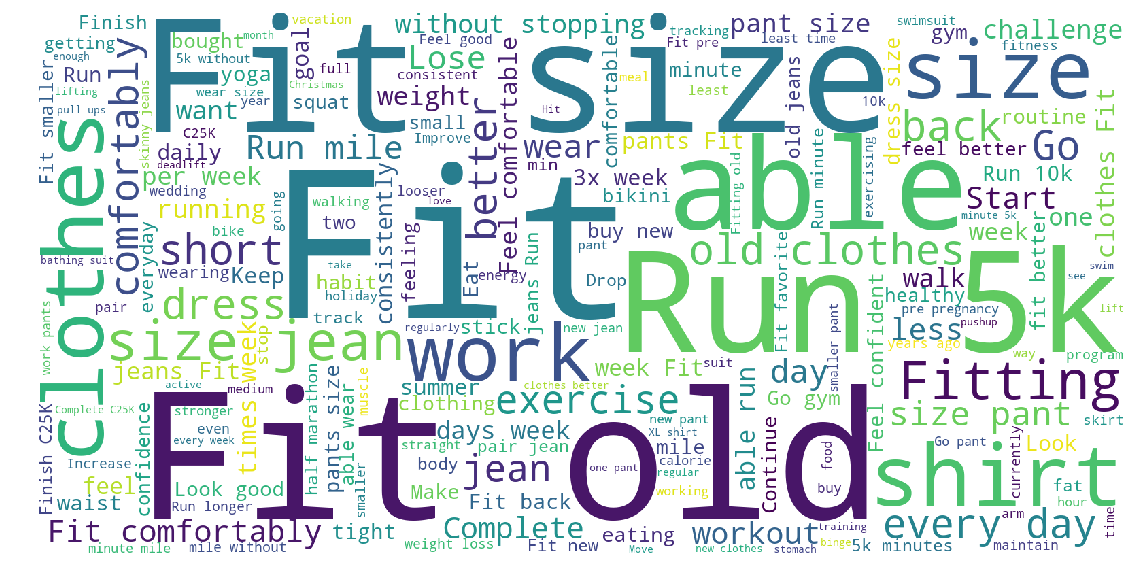

In [243]:
# Create and generate a word cloud image:
num_nsv = all
text = " ".join(review for review in big_df['NSV Text'])
wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(text)

# Display the generated image:
plt.figure( figsize=(20,10), facecolor='w')
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig(f'./figures/nsv_{num_nsv}_wordcloud.png', facecolor='w', bbox_inches='tight')

In [244]:
text

'finish the 10k under 44mins Fit into next size down jeans Run More Reach week 7 in c25k Walk/run at least 3x a week  Run longer distances, lift heavier - be a YETI!! ROAR!!!!!!!!!!! Start going to the gym. Finish the challenge for once Complete Couch25k! Fit an L t-shirt  Stay on Track I would love to be able to comfortable cosplay April O’Neil Manage food cravings and habits  Toning up somewhat! Fit into old pants.  jog 30 min without stopping My NSV for this challenge will be to not obsess to much about the scale and calories.  Fit into old clothes Workout a minimum of 3 days per week every week Consistently work out Start running and lifting Run 5K in <35 mins Find balance and create consistent healthy eating habits Be able to do a regular (non-incline) pushup Wear THE booty shorts Start going to workout classes Have no question whether im at my surgery weight or not. Surgery is on May 22nd. Keep my binging at a minimum during a stressful time at work, tracking the bingest and reco

In [174]:
texts=["dog cat fish","dog cat cat","fish bird", 'bird']
cv = CountVectorizer()
cv_fit=cv.fit_transform(texts)

print(cv.get_feature_names())
print(cv_fit.toarray())
#['bird', 'cat', 'dog', 'fish']
#[[0 1 1 1]
# [0 2 1 0]
# [1 0 0 1]
# [1 0 0 0]]
print(cv_fit.toarray().sum(axis=0))
#[2 3 2 2]

['bird', 'cat', 'dog', 'fish']
[[0 1 1 1]
 [0 2 1 0]
 [1 0 0 1]
 [1 0 0 0]]
[2 3 2 2]


In [163]:
# check these out 
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
def tokenize_normalize(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ", tweet)
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [168]:
# the sklearn vectorizer scans our corpus, build the vocabulary, and changes text into vectors
vectorizer = CountVectorizer(
    strip_accents='unicode', 
    lowercase=True, 
    tokenizer=tokenize_normalize,
    min_df=2,
    ngram_range=(1,4),  # you may want to try 2 grams. The vocab will get very large though
)
# first learn the vocabulary
vectorizer.fit(big_df['NSV Text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 4), preprocessor=None, stop_words=None,
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_normalize at 0x7f996a236268>,
        vocabulary=None)

In [169]:
# take a peek at the vocabulary learnt. We have the terms and the counts
print( list(vectorizer.vocabulary_.items())[:10] )
print("\n vocabulary size {}".format(len(vectorizer.vocabulary_)))

[('k', 1120), ('min', 1443), ('k min', 1131), ('next', 1534), ('size', 1987), ('jean', 1077), ('next size', 1538), ('size jean', 2002), ('c', 290), ('c k', 291)]

 vocabulary size 2624


In [ ]:
X = {}  # dict of [N, d] data matrix
y = {}  # dict of [N,] labels
X['train'] = vectorizer.transform(train.text).toarray()
X['val'] = vectorizer.transform(val.text).toarray()
X['test'] = vectorizer.transform(test.text).toarray()